For linear initial value problems, stability analysis can be performed by:

1.  Computing the eigenvalues $\lambda_j$ of the ODE system.
2.  Determining the maximal timestep $h$ such that $h \lambda_j$ lies inside the absolute stability region of the time stepping method.

This is particularly useful when applying the method of lines to a PDE system; in this case, the eigenvalues come from the semi-discretization of the PDE.  Here we show how this can be done in NodePy with some simple examples.

In [34]:
from matplotlib import pyplot as plt
from nodepy import rk, semidisc, lm
import numpy as np

First we load the classical method of Kutta and the simple first-order upwind semi-discretization of the advection equation (with periodic boundary conditions.

In [438]:
rk4 = rk.loadRKM('RK44')

alpha = [-1, 1]
beta = [0, -1]
alpha.reverse()
beta.reverse()
alpha = np.array(alpha)
beta = np.array(beta)
lm1 = lm.LinearMultistepMethod(alpha=alpha, beta=beta)

alpha = [-1, 1, 0]
beta = [0, -1.5, 0.5]
alpha.reverse()
beta.reverse()
alpha = np.array(alpha)
beta = np.array(beta)
lm2 = lm.LinearMultistepMethod(alpha=alpha, beta=beta)

alpha = [-1, 1/3, 5/9, 1/9]
beta = [0, -16/9, 0, 0]
alpha.reverse()
beta.reverse()
alpha = np.array(alpha)
beta = np.array(beta)
lm3 = lm.LinearMultistepMethod(alpha=alpha, beta=beta)

alpha = [-1, 1.49323762497707, -0.574370781405754, 0.0855838379295368, -0.00445068150085398]
beta = [0, -2.10313656405320, 2.80393876806197, -1.68484817541425, 0.400601121454727 ]
alpha.reverse()
beta.reverse()
alpha = np.array(alpha)
beta = np.array(beta)

lm4 = lm.LinearMultistepMethod(alpha=alpha, beta=beta)
# ab3=lm.Adams_Bashforth(3)
upwind = semidisc.upwind_advection_matrix(100,dx=0.1)

lm1.is_zero_stable() True
lm1.order() 1
lm2.is_zero_stable() True
lm2.order() 2
lm3.is_zero_stable() True
lm3.order() 2
lm4.is_zero_stable() True
lm4.order() 4


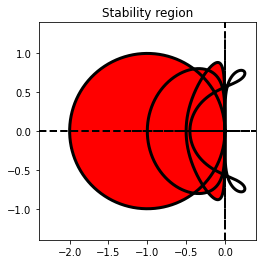

In [495]:
lm1.plot_stability_region()
print('lm1.is_zero_stable()', lm1.is_zero_stable())
print('lm1.order()',lm1.order())

lm2.plot_stability_region()
print('lm2.is_zero_stable()', lm2.is_zero_stable())
print('lm2.order()',lm2.order())

lm3.plot_stability_region()
print('lm3.is_zero_stable()', lm3.is_zero_stable())
print('lm3.order()',lm3.order(tol=0.1))

lm4.plot_stability_region()
print('lm4.is_zero_stable()', lm4.is_zero_stable())
print('lm4.order()',lm4.order(tol=0.1))


True

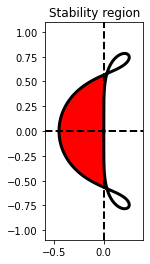

In [482]:
lm4.plot_stability_region()
lm4.is_zero_stable()

In [483]:
print('lm1.latex()', lm1.latex())
print('lm3.latex()', lm3.latex())
print('lm3.latex()', lm4.latex())


lm1.latex() \begin{align} y_{n + 1} - y_{n} = h f(y_{n})\end{align}
lm3.latex() \begin{align} y_{n + 3} -0.333 y_{n + 2} -0.556 y_{n + 1} -0.111 y_{n} = 1.778h f(y_{n + 2})\end{align}
lm3.latex() \begin{align} y_{n + 4} -1.493 y_{n + 3} + 0.574 y_{n + 2} -0.086 y_{n + 1} + 0.004 y_{n} = 2.103h f(y_{n + 3}) -2.804h f(y_{n + 2}) + 1.685h f(y_{n + 1}) -0.401h f(y_{n})\end{align}


Now we can use the method `linearly_stable_step_size` to automatically compute the maximum absolutely stable step size for this combination.  As a bonus, the function shows a plot of the absolute stability region and the (maximally) scaled spectrum.

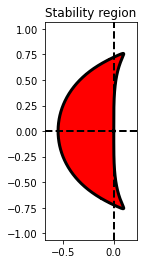

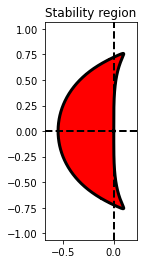

In [484]:
# rk.linearly_stable_step_size(rk4,upwind)
ab3.plot_stability_region()

We can do the same for another linear spatial discretization.

0.0013114268523072923

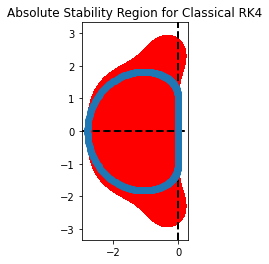

In [485]:
spectral = semidisc.load_semidisc('spectral difference advection',order=6)
rk.linearly_stable_step_size(rk4,spectral.L)

For a nonlinear discretization, like WENO, a simple approach is to consider the eigenvalues of one or more linearizations.  Here we use the linearization given in the limit of a very smooth function.

0.017329720215911608

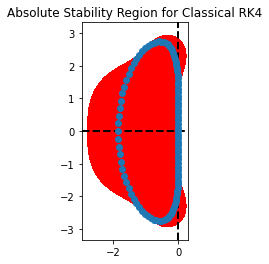

In [486]:
weno5 = semidisc.weno5_linearized_matrix(100)
rk.linearly_stable_step_size(rk4,weno5)

The next example uses a semi-discretization of an advection-diffusion PDE.  For this stiff PDE, RK4 requires a very small step size and would be inefficient.

6.958007812499993e-05

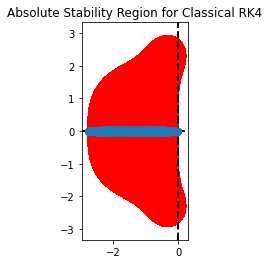

In [487]:
centered_diff = semidisc.centered_advection_diffusion_matrix(10.,1.,N=100)
rk.linearly_stable_step_size(rk4,centered_diff)

A better choice would be a method with good real-axis stability, like the Runge-Kutta-Chebyshev methods.  Let's try one.

0.00015745162963867173

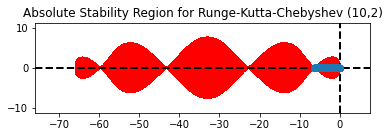

In [488]:
rkc = rk.RKC2(10)
rk.linearly_stable_step_size(rkc,centered_diff)

Unfortunately, this doesn't work as well as hoped because the PDE in question has a small but non-zero convective component.  We can modify the RKC method in order to accommodate this:

0.0016093254089355451

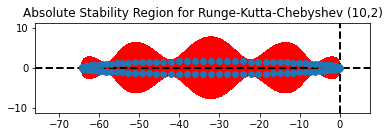

In [489]:
rkc_damped = rk.RKC2(10, epsilon=0.2)
rk.linearly_stable_step_size(rkc_damped,centered_diff)

Notice that the step size allowed is 10x larger than with the undamped RKC method, and over 20x larger than with the RK4 method.

How does the real-axis stability compare between the damped and undamped RKC methods?

In [490]:
rkc.real_stability_interval()

22.802433359971374

In [491]:
rkc_damped.real_stability_interval()

64.37373670307043

As a last example, here's an interactive widget that lets you design an RKC method (choosing the number of stages and the damping parameter) and see the resulting allowed step size.  Experiment with it.  How much damping do you need?  Does it depend on the number of stages?  What method is most efficient?

In [492]:
from ipywidgets import interact, IntSlider, FloatSlider

In [493]:
def plot_rkc2_stability_region(s=5,epsilon=0.):
    rkc = rk.RKC2(s, epsilon)
    h = rk.linearly_stable_step_size(rkc,centered_diff, tol=1.e-13)
    print('Maximum stable step size: {:.3e}'.format(h))
    plt.show()

In [494]:
interact(plot_rkc2_stability_region,
         s=IntSlider(min=1,max=20,value=5),
         epsilon=FloatSlider(min=0.,max=2.,step=0.01,value=0.));

interactive(children=(IntSlider(value=5, description='s', max=20, min=1), FloatSlider(value=0.0, description='…